In [5]:
## STANDARD IMPORTS
import os
import time
import h5py
import numpy as np
import numpy.ma as ma
import pandas as pd
import json

!pip install ../../../h5flow
import h5flow
from h5flow.data import dereference

## 3D PLOTTING
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm

Processing /Users/james/DUNE/h5flow
  Preparing metadata (setup.py) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31486 sha256=808fa0b571a96b889af3d8c9c6865c1c3c4463ace80a6a7ed2f936279745f284
  Stored in directory: /private/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/pip-ephem-wheel-cache-uzekq3hi/wheels/24/88/52/69f8c19ba5cdb192c9c8611f03e4d3b4e2b4c27d2131bc4e20
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


In [6]:
dirname = 'mc_processed_MiniRun5_1E19_RHC.flow.0000000.FLOW_TrapType_evts_all'
spes_filename = dirname+'/spes_evt.npz'
noise_filename = dirname+'/noise_evt.npz'
config_filename = dirname+'/config.json'
hits_filename = dirname+'/hits_evt.npz'
hits_config_filename = dirname+'/hits_config.json'
true_hits_filename = dirname+'/true_nu_int.csv'

# check if true hits file exists
if os.path.exists(true_hits_filename):
    true_hits = pd.read_csv(true_hits_filename)
    print(true_hits.head())

# print configuration and hit configuration
with open(config_filename) as json_file:
    config = json.load(json_file)
    print(json.dumps(config, indent=4))
with open(hits_config_filename) as json_file:
    hits_config = json.load(json_file)
    print(json.dumps(hits_config, indent=4))

   file_idx  event_id    start_time  start_time_idx  tpc_num        v_x  \
0       0.0       1.0  1.200006e+06      480.613490      1.0  32.032982   
1       0.0       1.0  1.200001e+06      150.964225      2.0  49.809910   
2       0.0       2.0  2.400009e+06      616.402889      6.0 -18.539982   
3       0.0       2.0  2.400008e+06      616.383821      7.0 -36.242825   
4       0.0       3.0  3.600005e+06      689.095372      2.0  38.561604   

         v_y        v_z  
0 -27.283056  36.971001  
1 -48.442410 -59.636707  
2 -54.685654 -59.716122  
3  -6.535629 -59.464272  
4 -39.889172 -30.570784  
{
    "timestamp": "2025-02-14 14:23:21.199507",
    "filename": "../hdf5s/MiniRun5_1E19_RHC.flow.0000000.FLOW.hdf5",
    "is_data": false,
    "save_truth": true,
    "summed": "TrapType",
    "max_evts": null,
    "calib_filename": "calibration/mc_calib.csv",
    "geom_filename": "geom_files/light_module_desc-4.0.0.csv",
    "channel_status_filename": "channel_status/channel_status.csv",


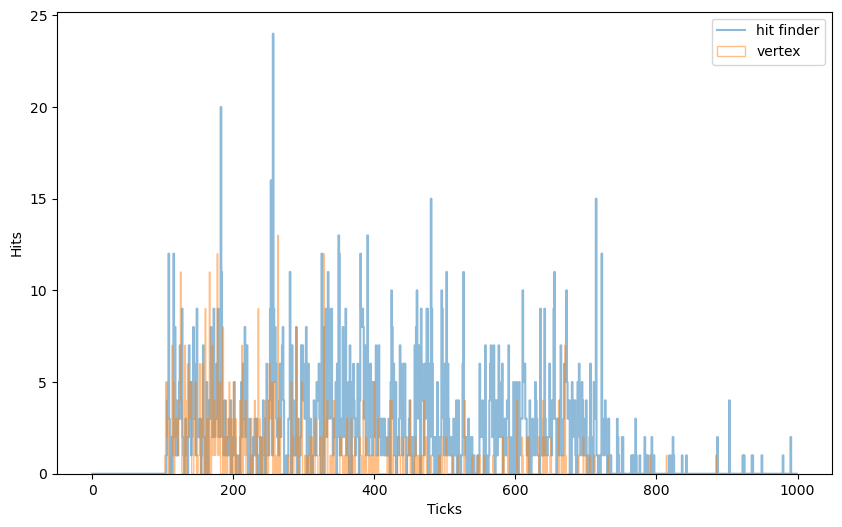

In [7]:
# load true hits
true_hits = pd.read_csv(true_hits_filename)
true_hit_idxs = true_hits['start_time_idx'].values

# load ticks histogram of all hits
hits_file = np.load(hits_filename)
hits_arr = hits_file['arr_0']
flat_hits = np.sum(hits_arr, axis=(0,1))

# plot ticks histogram of all hits
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.step(range(len(flat_hits)), flat_hits, label='hit finder', alpha=0.5)
ax.hist(true_hit_idxs, bins=range(len(flat_hits)), histtype='step', label='vertex', alpha=0.5)
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.show()




In [8]:
import scipy.stats
def clopper_pearson_interval(k, n, alpha=0.6827):
    alpha = 1 - alpha
    lo = 0.5 * scipy.stats.beta.ppf(alpha / 2, k, n - k + 1)
    hi = 1 - 0.5 * scipy.stats.beta.ppf(alpha / 2, k + 1, n - k)
    return lo, hi

In [72]:
def plot_waveform(i_evt_lrs, time_bins, wvfm, hit_where, i_mask, true_hits, logy=False):

  fig = plt.figure(figsize=(12, 3))
  # set a title
  fig.suptitle(f'Event {i_evt_lrs}, TPC {i_mask[0] // 2}')

  if logy==False:
  # Linear plot
    # acls
    plt.plot(time_bins, wvfm[0], label='ACL', color='red', alpha=0.5)
    plt.plot(hit_where[0] * 16/1000, wvfm[0][hit_where[0]], 'x', color='red')
    # lcms
    plt.plot(time_bins, wvfm[1], label='LCMS', color='blue', alpha=0.5)
    plt.plot(hit_where[1] * 16/1000, wvfm[1][hit_where[1]], 'x', color='blue')
    # baseline
    plt.axhline(0, color='k', linestyle=':', alpha=0.5)
    # true hits
    for hit_idx in true_hits:
      plt.axvline(hit_idx * 16/1000, color='purple', linestyle=':', alpha=0.5, label='True hits')
    plt.xlabel('Time (us)')
    plt.ylabel('SPEs')
    plt.legend()

  else:
  # Logarithmic plot
    # acls
    plt.plot(time_bins, wvfm[0] + 1, label='ACL', color='red', alpha=0.5)
    plt.plot(hit_where[0] * 16/1000, wvfm[0][hit_where[0]] + 1, 'x', color='red')
    # lcms
    plt.plot(time_bins, wvfm[1] + 1, label='LCMS', color='blue', alpha=0.5)
    plt.plot(hit_where[1] * 16/1000, wvfm[1][hit_where[1]] + 1, 'x', color='blue')
    # baseline
    plt.axhline(1, color='k', linestyle=':', alpha=0.5)
    # true hits
    for hit_idx in true_hits:
      plt.axvline(hit_idx * 16/1000, color='purple', linestyle=':', alpha=0.5)
    plt.yscale('log')
    plt.xlabel('Time (us)')

  plt.tight_layout()
  plt.show()

In [81]:
from scipy.ndimage import uniform_filter1d

# load hit finder config
with open(hits_config_filename) as json_file:
    hits_config = json.load(json_file)
n_noise_factor = hits_config['n_noise_factor']
n_bins_rolled = hits_config['n_bins_rolled']
n_sqrt_rt_factor = hits_config['n_sqrt_rt_factor']
pe_weight = hits_config['pe_weight']

# loading events
time_bins = np.linspace(0, 16, 1000)

# wvfms
summed_wvfms_file = np.load(spes_filename)
summed_wvfms = np.array(summed_wvfms_file['arr_0'])

# noise thresholds
heights_file = np.load(noise_filename)
heights = np.array(heights_file['arr_0'])

# loading hits
hits_file = np.load(hits_filename)
hits = np.array(hits_file['arr_0'])

# loading true hits
true_hits = pd.read_csv(true_hits_filename)

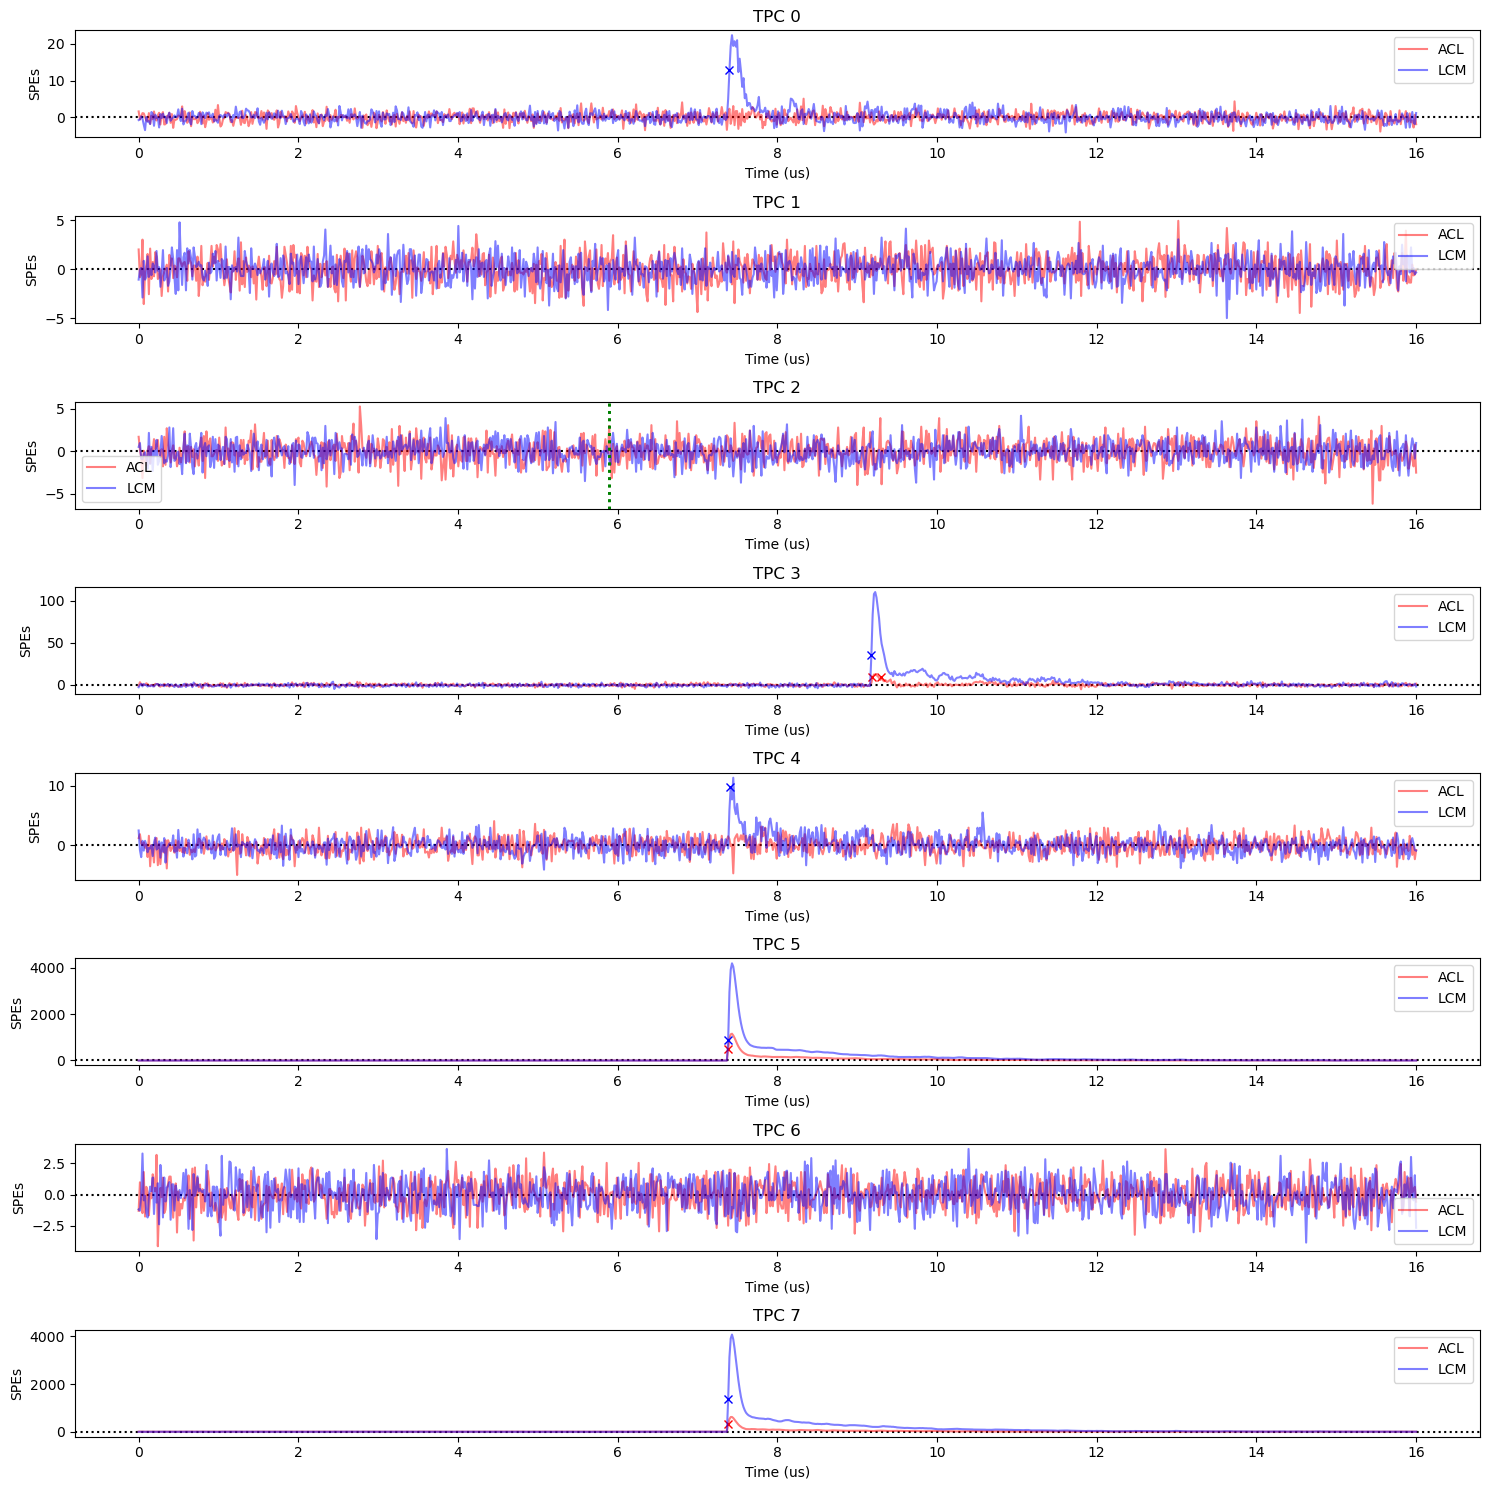

In [87]:
# plotting script to plot the summed traptype waveforms per tpc with interactions
def plot_summed_trap_waveform_per_tpc_with_interactions(i_evt, time_bins, summed_wvfms, hits, true_hits):

  # 2x2 TPC subplot grid, each with traptype sum waveforms
  fig, axs = plt.subplots(8, 1, figsize=(15, 15))

  for tpc in range(8):
    acl_mask = 2*tpc
    lcm_mask = 2*tpc + 1

    axs[tpc].axhline(0, color='k', linestyle=':')

    # get wvfm, threshold, and hits for the event
    acl_wvfm = summed_wvfms[i_evt, acl_mask]
    acl_hit = hits[i_evt, acl_mask]
    acl_hit_where = np.where(acl_hit)[0]

    lcm_wvfm = summed_wvfms[i_evt, lcm_mask]
    lcm_hit = hits[i_evt, lcm_mask]
    lcm_hit_where = np.where(lcm_hit)[0]

    axs[tpc].plot(time_bins, acl_wvfm, label='ACL', color='red', alpha=0.5)
    axs[tpc].plot(acl_hit_where * 16/1000, acl_wvfm[acl_hit_where], 'x', color='red')

    axs[tpc].plot(time_bins, lcm_wvfm, label='LCM', color='blue', alpha=0.5)
    axs[tpc].plot(lcm_hit_where * 16/1000, lcm_wvfm[lcm_hit_where], 'x', color='blue')

    # true hits
    true_hits_tpc_evt = true_hits[(true_hits['event_id'] == i_evt) & (true_hits['tpc_num'] == tpc)]['start_time_idx'].values
    true_hits_idx = np.array(true_hits_tpc_evt)
    for hit_idx in true_hits_idx:
      axs[tpc].axvline(hit_idx * 16/1000, color='green', linestyle=':', linewidth=2)

    axs[tpc].set_xlabel('Time (us)')
    axs[tpc].set_ylabel('SPEs')
    axs[tpc].set_title(f'TPC {tpc}')

    # legend
    axs[tpc].legend()

  plt.tight_layout()
  plt.show()


# plot summed traptype waveforms per tpc with interactions
i_evt_lrs = 100
plot_summed_trap_waveform_per_tpc_with_interactions(i_evt_lrs, time_bins, summed_wvfms, hits, true_hits)

In [77]:
def plot_all_tpc_waveform(wvfms, time_bins, hit_where, i_evt_lrs, i_mask, true_hits=None):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
  # set a title
  fig.suptitle(f'Event {i_evt_lrs}, TrapType {i_mask % 2}')

  # Linear plot
  for i,wvfm in enumerate(wvfms):
    ax1.plot(time_bins, wvfm, label=f'TPC {i}')
    label = 'Rec hits' if i == 0 else None
    ax1.plot(hit_where[i] * 16/1000, wvfm[hit_where[i]], 'x', color='k', label=label)
  for hit_idx in true_hits:
    label = 'True hits' if i == 0 else None
    ax1.axvline(hit_idx * 16/1000, color='purple', linestyle=':', alpha=0.5, label=label)
  ax1.axhline(0, color='k', linestyle=':', alpha=0.5)
  ax1.set_xlabel('Time (us)')
  ax1.set_ylabel('SPEs')
  ax1.legend()

  # Logarithmic plot
  for i,wvfm in enumerate(wvfms):
    ax2.plot(time_bins, wvfm + 1, label=f'TPC {i}')
    label = 'Rec hits' if i == 0 else None
    ax2.plot(hit_where[i] * 16/1000, wvfm[hit_where[i]] + 1, 'x', color='k', label=label)
  for hit_idx in true_hits:
    label = 'True hits' if i == 0 else None
    ax2.axvline(hit_idx * 16/1000, color='purple', linestyle=':', alpha=0.5, label=label)
  ax2.axhline(1, color='k', linestyle=':', alpha=0.5)
  ax2.set_yscale('log')
  ax2.set_xlabel('Time (us)')
  #ax2.set_ylim(0.1, wvfm.max()*1.1)

  plt.tight_layout()
  plt.show()

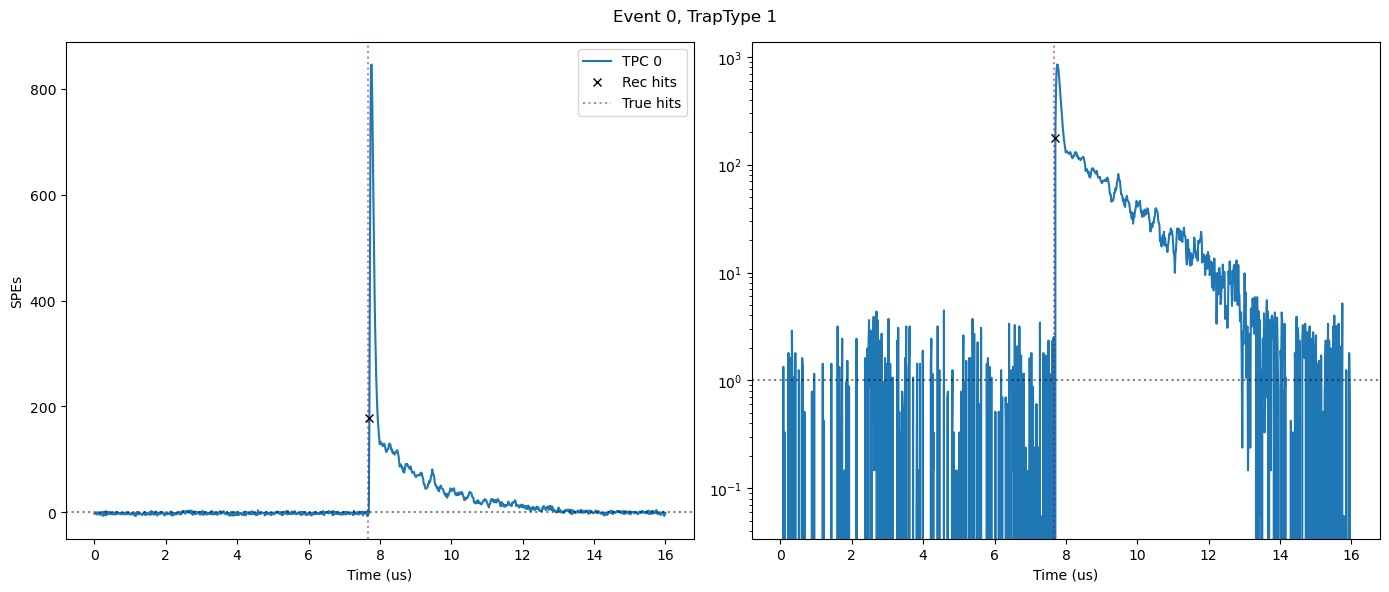

In [ ]:
true_times = []
rec_times = []
true_incl_times = []

for i_evt_lrs in light_wvfm_ref: #[:10]:

    wvfms = []
    hits_where = []
    true_hits_where = []
    true_hits_incl_where = []

    # find the corresponding spill_id for light wvfm ref = i_evt_lrs
    #print(f'light wvfm ref {i_evt_lrs}')
    index = np.where(light_wvfm_ref==i_evt_lrs)[0][0]
    #print(index)
    spill_id_lwr = spill_id[index]
    true_hits_evt = true_hits[(true_hits['event_id'] == spill_id_lwr) & (true_hits['tpc_num'] > -1)]
    if len(true_hits_evt) == 0:
        continue

    for i_tpc in range(0, 4):
        #print(f'Event {i_evt_lrs} has spill_id {spill_id_lwr}')
        true_hits_tpc = true_hits[(true_hits['tpc_num'] == i_tpc) & (true_hits['event_id'] == spill_id_lwr)]
        #true_hits_tpc = true_hits[(true_hits['event_id'] == spill_id_lwr)]
        true_hits_idx = true_hits_tpc['start_time_idx'].values + 100
        if len(true_hits_idx) == 0:
            continue

        i_mask = 2*i_tpc + 1 # 2 * TPC + TrapType
        wvfm = summed_wvfms[i_evt_lrs,i_mask]
        median = np.median(wvfm)
        mad = np.median(np.abs(wvfm - median))
        mad_threshold = 5*mad
        wvfm_rolled = np.roll(wvfm, n_bins_rolled)
        rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
        sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
        dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
        height = heights[i_evt_lrs,i_mask]

        hit = hits[i_evt_lrs,i_mask]
        hit_where = np.where(hit)[0]

        wvfms.append(wvfm)
        hits_where.append(hit_where)
        true_hits_where.append(true_hits_idx)

    true_hits_tpc = true_hits[(true_hits['tpc_num'] == -1) & (true_hits['event_id'] == spill_id_lwr)]
    #true_hits_tpc = true_hits[(true_hits['event_id'] == spill_id_lwr)]
    true_hits_idx = true_hits_tpc['start_time_idx'].values + 100
    if len(true_hits_idx) == 0:
        continue
    true_hits_incl_where.append(true_hits_idx)

    #print(hits_where)
    #print(true_hits_where)

    true_times.append(true_hits_where)
    rec_times.append(hits_where)
    true_incl_times.append(true_hits_incl_where)

    if i_evt_lrs == 0:
        plot_all_tpc_waveform(wvfms, time_bins, hits_where, i_evt_lrs, i_mask, true_hits_where)

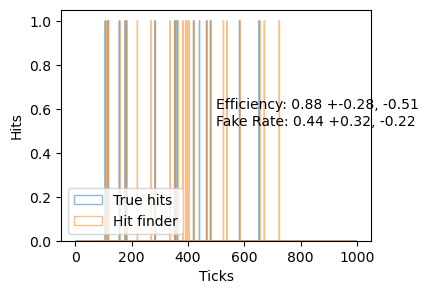

In [ ]:
true_times_list = []
rec_times_list = []

for i in range(len(true_times)):
    for j in range(len(true_times[i][0])):
      true_times_list.append(true_times[i][0][j])
    for j in range(len(rec_times[i][0])):
      rec_times_list.append(rec_times[i][0][j])

true_times_flat = np.array(true_times_list)
rec_times_flat = np.array(rec_times_list)

# for every combination of true and rec times , calculate the residuals
residuals = []
true = 0
rec_true = 0
rec = 0
#true_ext = 0
for i in range(len(true_times)):
    for j in range(len(rec_times[i][0])):
        rec+=1
    for j in range(len(true_times[i][0])):
        true+=1
    #for j in range(len(true_incl_times)):
    #    true_ext+=1
        for k in range(len(rec_times[i][0])):
            # conditions
            time_diff = rec_times[i][0][k] - true_times[i][0][j] < 6
            time_ord = rec_times[i][0][k] - true_times[i][0][j] > 0
            if time_diff and time_ord:
                # check if hit lies between pair
                residuals.append(true_times[i][0][j] - rec_times[i][0][k])
                rec_true+=1
            '''
            # for external to tpcs
            time_diff = rec_times[i][0][k] - true_incl_times[j][0] < 6
            time_ord = rec_times[i][0][k] - true_incl_times[j][0] > 0
            if time_diff and time_ord:
                # check if hit lies between pair
                residuals.append(true_incl_times[j][0] - rec_times[i][0][k])
                rec_true+=1
            '''


efficiency = rec_true/true
d_efficiency = clopper_pearson_interval(rec_true, true)

fake_tate = 1 - rec_true/rec
d_fake_rate = clopper_pearson_interval(rec_true, rec)

#eff_incl =

bins = np.linspace(0, 1001, 1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(true_times_flat, bins=bins, histtype='step', label='True hits', alpha=0.5)
ax.hist(rec_times_flat, bins=bins, histtype='step', label='Hit finder', alpha=0.5)
text = f'Efficiency: {efficiency:.2f} +{d_efficiency[1] - efficiency:.2f}, -{efficiency - d_efficiency[0]:.2f}'
text += f'\nFake Rate: {fake_tate:.2f} +{d_fake_rate[1] - fake_tate:.2f}, -{fake_tate - d_fake_rate[0]:.2f}'
ax.text(0.5, 0.5, text, transform=ax.transAxes)
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.show()

Integral between -5 and 0 = 14


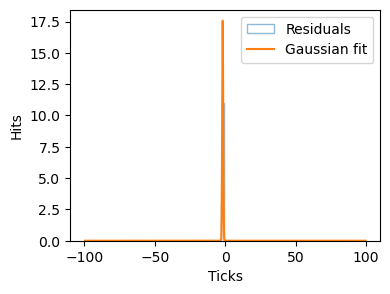

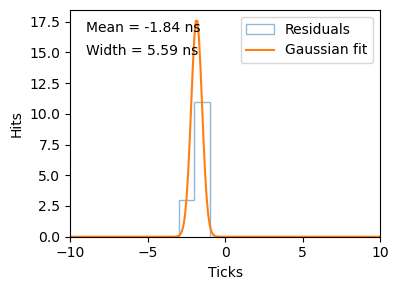

In [ ]:
residuals = np.array(residuals)
# gausssian fit
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
from scipy.optimize import curve_fit

# fit the residuals
bins = np.linspace(-100, 100, 201)
hist, bin_edges = np.histogram(residuals, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# integral of histogram between -5 and 0
integral = np.sum(hist[np.where((bin_centers > -5) & (bin_centers < 0))])
print(f'Integral between -5 and 0 = {integral}')
# set upper and lower bounds for the fit parameter 0 based on integral+-sqrt(integral)
p0 = [integral, -1, 1]
l_lower = integral - np.sqrt(integral)
l_upper = integral + np.sqrt(integral)
bounds = ([l_lower, -10, 0], [l_upper, 0, 10])
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[integral, -1, 1], bounds=bounds)
new_bin_centers = np.linspace(bin_centers[0], bin_centers[-1], 2001)

# plot the residuals
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(residuals, bins=bins, histtype='step', label='Residuals', alpha=0.5)
ax.plot(new_bin_centers, gaussian(new_bin_centers, *popt), label='Gaussian fit')
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.show()

# plot the residuals with a zoom
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(residuals, bins=bins, histtype='step', label='Residuals', alpha=0.5)
ax.plot(new_bin_centers, gaussian(new_bin_centers, *popt), label='Gaussian fit')
# print text of mean of gaussian
text = f'Mean = {popt[1]:.2f} ns'
ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')
# print text of width of gaussian in ns
text = f'Width = {popt[2]*16:.2f} ns'
ax.text(0.05, 0.85, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.tight_layout()
plt.xlim(-10, 10)
plt.show()

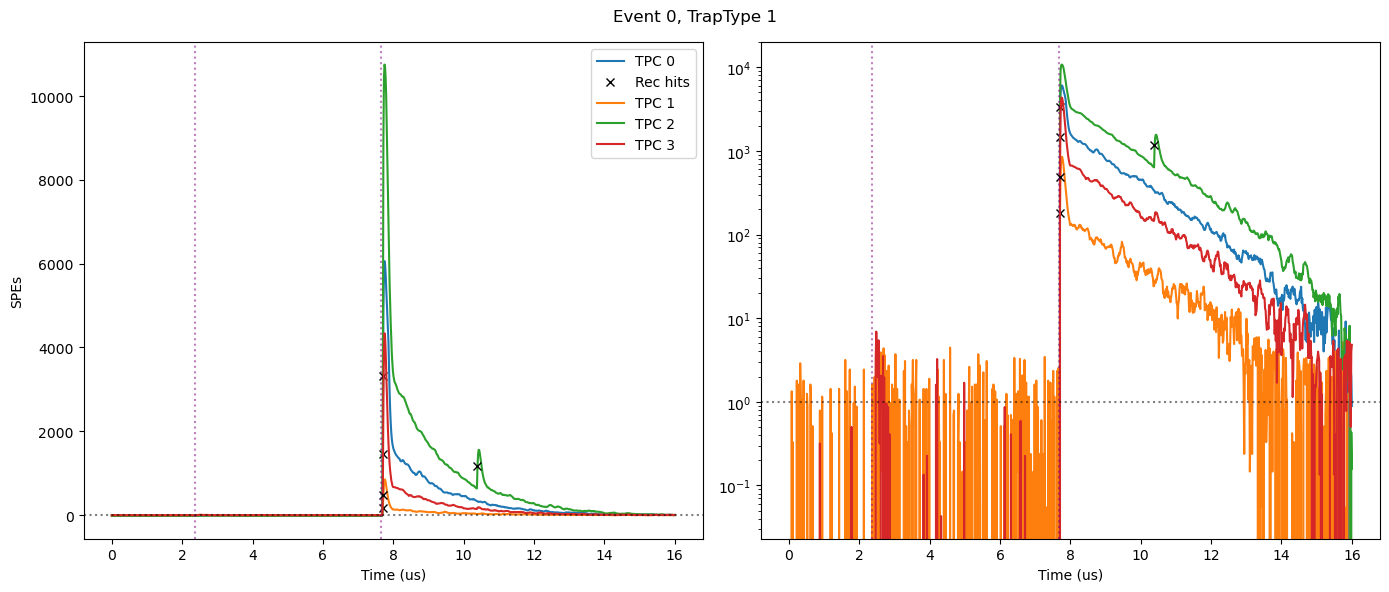

In [ ]:
true_times = []
rec_times = []

for i_evt_lrs in light_wvfm_ref[:20]:

    wvfms = []
    hits_where = []
    true_hits_where = []

    # find the corresponding spill_id for light wvfm ref = i_evt_lrs
    #print(f'light wvfm ref {i_evt_lrs}')
    index = np.where(light_wvfm_ref==i_evt_lrs)[0][0]
    #print(index)
    spill_id_lwr = spill_id[index]
    true_hits_evt = true_hits[(true_hits['event_id'] == spill_id_lwr)]# & (true_hits['tpc_num'] > -1)]
    if len(true_hits_evt) == 0:
        continue
    true_hits_idx = true_hits_evt['start_time_idx'].values + 100

    for i_tpc in range(0, 4):
        #print(f'Event {i_evt_lrs} has spill_id {spill_id_lwr}')
        #true_hits_tpc = true_hits[(true_hits['tpc_num'] == i_tpc) & (true_hits['event_id'] == spill_id_lwr)]
        #true_hits_tpc = true_hits[(true_hits['event_id'] == spill_id_lwr)]
        #true_hits_idx = true_hits_tpc['start_time_idx'].values
        #if len(true_hits_idx) == 0:
        #    continue

        i_mask = 2*i_tpc + 1 # 2 * TPC + TrapType
        wvfm = summed_wvfms[i_evt_lrs,i_mask]
        median = np.median(wvfm)
        mad = np.median(np.abs(wvfm - median))
        mad_threshold = 5*mad
        wvfm_rolled = np.roll(wvfm, n_bins_rolled)
        rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
        sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
        dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
        height = heights[i_evt_lrs,i_mask]

        hit = hits[i_evt_lrs,i_mask]
        hit_where = np.where(hit)[0]

        wvfms.append(wvfm)
        hits_where.append(hit_where)
    true_hits_where.append(true_hits_idx)

    #print(hits_where)
    #print(true_hits_where)

    true_times.append(true_hits_where)
    rec_times.append(hits_where)

    if i_evt_lrs == 0:
        plot_all_tpc_waveform(wvfms, time_bins, hits_where, i_evt_lrs, i_mask, true_hits_idx)

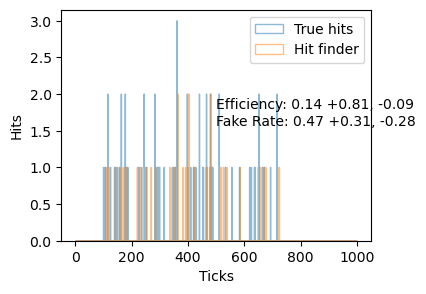

In [ ]:
for i in range(len(true_times)):
    for j in range(len(true_times[i][0])):
      true_times_list.append(true_times[i][0][j])
    for j in range(len(rec_times[i][0])):
      rec_times_list.append(rec_times[i][0][j])

true_times_flat = np.array(true_times_list)
rec_times_flat = np.array(rec_times_list)

# for every combination of true and rec times , calculate the residuals
residuals = []
true = 0
rec_true = 0
rec = 0
for i in range(len(true_times)):
    for j in range(len(rec_times[i][0])):
        rec+=1
    for j in range(len(true_times[i][0])):
        true+=1
        for k in range(len(rec_times[i][0])):
            # conditions
            time_diff = rec_times[i][0][k] - true_times[i][0][j] < 6
            time_ord = rec_times[i][0][k] - true_times[i][0][j] > 0
            if time_diff and time_ord:
                # check if hit lies between pair
                residuals.append(true_times[i][0][j] - rec_times[i][0][k])
                rec_true+=1

efficiency = rec_true/true
d_efficiency = clopper_pearson_interval(rec_true, true)

fake_tate = 1 - rec_true/rec
d_fake_rate = clopper_pearson_interval(rec_true, rec)

bins = np.linspace(0, 1001, 1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(true_times_flat, bins=bins, histtype='step', label='True hits', alpha=0.5)
ax.hist(rec_times_flat, bins=bins, histtype='step', label='Hit finder', alpha=0.5)
text = f'Efficiency: {efficiency:.2f} +{d_efficiency[1] - efficiency:.2f}, -{efficiency - d_efficiency[0]:.2f}'
text += f'\nFake Rate: {fake_tate:.2f} +{d_fake_rate[1] - fake_tate:.2f}, -{fake_tate - d_fake_rate[0]:.2f}'
ax.text(0.5, 0.5, text, transform=ax.transAxes)
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.show()

Integral between -5 and 0 = 9


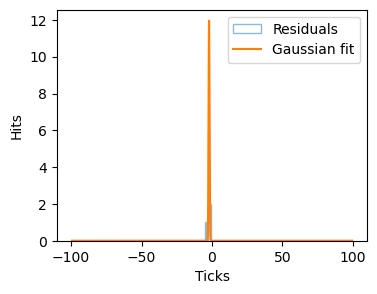

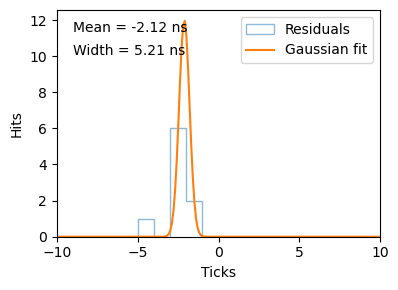

In [ ]:
residuals = np.array(residuals)
# gausssian fit
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
from scipy.optimize import curve_fit

# fit the residuals
bins = np.linspace(-100, 100, 201)
hist, bin_edges = np.histogram(residuals, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# integral of histogram between -5 and 0
integral = np.sum(hist[np.where((bin_centers > -5) & (bin_centers < 0))])
print(f'Integral between -5 and 0 = {integral}')
# set upper and lower bounds for the fit parameter 0 based on integral+-sqrt(integral)
p0 = [integral, -1, 1]
l_lower = integral - np.sqrt(integral)
l_upper = integral + np.sqrt(integral)
bounds = ([l_lower, -10, 0], [l_upper, 0, 10])
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[integral, -1, 1], bounds=bounds)
new_bin_centers = np.linspace(bin_centers[0], bin_centers[-1], 2001)

# plot the residuals
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(residuals, bins=bins, histtype='step', label='Residuals', alpha=0.5)
ax.plot(new_bin_centers, gaussian(new_bin_centers, *popt), label='Gaussian fit')
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.show()

# plot the residuals with a zoom
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(residuals, bins=bins, histtype='step', label='Residuals', alpha=0.5)
ax.plot(new_bin_centers, gaussian(new_bin_centers, *popt), label='Gaussian fit')
# print text of mean of gaussian
text = f'Mean = {popt[1]:.2f} ns'
ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')
# print text of width of gaussian in ns
text = f'Width = {popt[2]*16:.2f} ns'
ax.text(0.05, 0.85, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.tight_layout()
plt.xlim(-10, 10)
plt.show()

Event 0 has spill_id 1, and light wvfm ref 0, and spill id 1


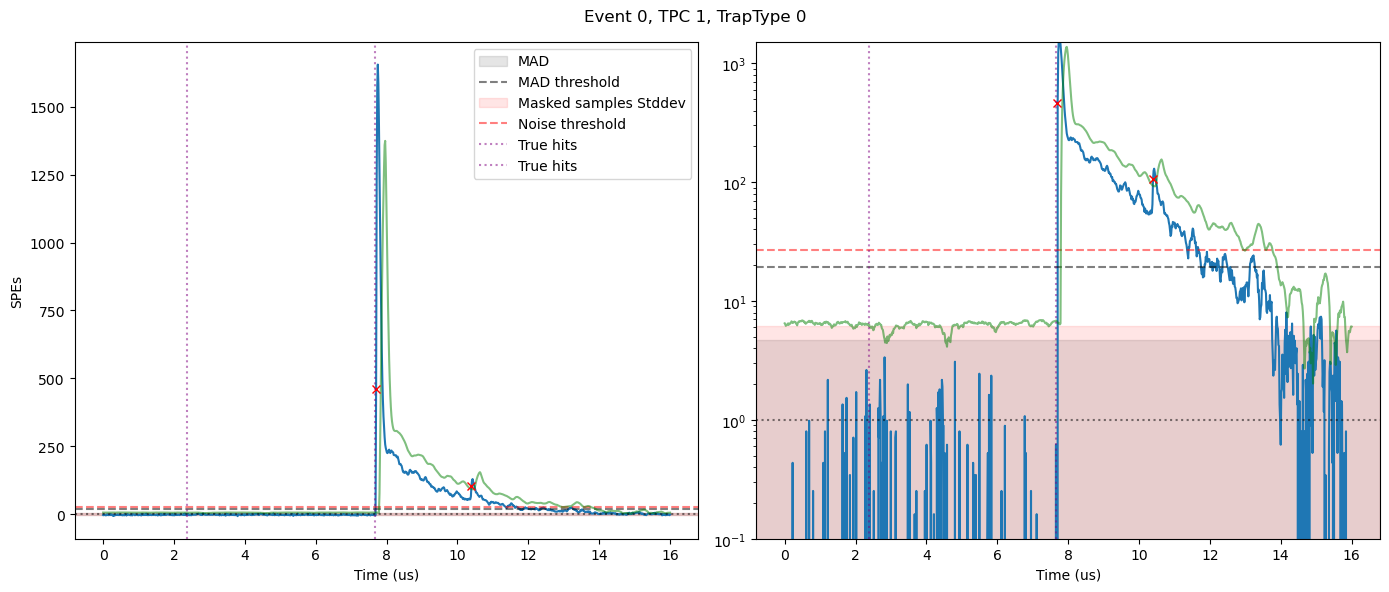

IndexError: index 0 is out of bounds for axis 0 with size 0

In [97]:
# plot the waveform of the trap with the highest wvfm in the event
for i_evt_lrs in range(5):#summed_wvfms.shape[0]):

  # skip events with no hits
  all_traps = summed_wvfms[i_evt_lrs]
  all_heights = heights[i_evt_lrs]
  all_hits = hits[i_evt_lrs]

  # mask with the most hits
  i_mask = np.argmax(all_hits.sum(axis=1))

  # get wvfm, threshold, and hits for the event
  wvfm = summed_wvfms[i_evt_lrs,i_mask]
  median = np.median(wvfm)
  mad = np.median(np.abs(wvfm - median))
  mad_threshold = 5*mad
  wvfm_rolled = np.roll(wvfm, n_bins_rolled)
  rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
  sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
  dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
  height = heights[i_evt_lrs,i_mask]

  hit = hits[i_evt_lrs,i_mask]
  hit_where = np.where(hit)[0]

  if len(hit_where) < 1:
    continue

  # find the corresponding spill_id for light wvfm ref = i_evt_lrs
  index = np.where(light_wvfm_ref==i_evt_lrs)[0][0]
  spill_id_lwr = spill_id[index]

  # print event number, spill_id, and light wvfm ref etc
  print(f'Event {i_evt_lrs} has spill_id {spill_id_lwr}, and light wvfm ref {light_wvfm_ref[index]}, and spill id {spill_id_lwr}')

  # get true hits for the event
  true_hits_evt = true_hits[(true_hits['event_id'] == spill_id_lwr)]
  true_hits_idx = true_hits_evt['start_time_idx'].values + 100

  plot_waveform(wvfm, time_bins, height, mad, 5.0, dynamic_threshold, hit_where, n_noise_factor, i_evt_lrs, i_mask, true_hits_idx)
  #break